# Goal:

In this notebook, we extract the coordinates of all the objects in the Fornax Deep Survey Dwarf Catalogue (FDSDC, Venhola et al. (2018)), and cross-match them to the coordinates of objects in the Space Fluff project, to see if any of them are present in the project. They would not end up in the final LSB catalogue by Venhola et al., since that is an addition to the FDSDC, however they might be relevant for our analysis, as some of them are LSBs rather than simply dwarfs. Users that classify these objects as fluffy galaxies are probably correct, then, even though a simple comparison to the likely ground truth (LSB catalogue) would disagree, for those objects.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from PIL import Image
from astropy import units as u

%matplotlib inline

In [2]:
def get_cols(df, cols):
    return df[cols].T.values

def get_column_names(s, df):
    cols = df.columns.tolist()
    return list(filter(lambda x: x.startswith(s), cols))

In [3]:
catalogue_targets = np.loadtxt('./sf_catalogue_targets.txt', dtype='str')

In [4]:
# df_votes.json is created in ../analysis/stack workflows/df_stacked.ipynb. 
#  Make sure to re-run that whenever we change something, 
#   otherwise we'll be working with stale data in this notebook
df_votes = pd.read_json('../analysis/stack workflows/df_votes.json')
df = pd.read_json('../analysis/stack workflows/df_stacked.json')

---

- Extract coordinates (RA, DEC) from FDSDC and check if any match with SpaceFluff objects

In [5]:
hdul = fits.open('./J_A+A_620_A165_dwarf.dat.fits')
header = hdul[0].header
data = hdul[1].data

col_names = data.columns.names

In [6]:
name_from_fdsdc, ras, decs = np.array([d[:3] for d in data]).T
ras = ras.astype(float)
decs = decs.astype(float)

In [7]:
names_in_fdsdc = []
indices = []
 
# if RA and DEC are each 2.1'' another target, that puts it at ~3 arcsec from the target. This falls within the range Venhola et al. use for their cross-matching
dist = (2.1*u.arcsec).to('deg') # using pythagorean theorem: sqrt(2.1^2 + 2.1^2) ~ 3 [arcsec]

for i, (ra, dec) in enumerate(zip(ras, decs)):
    filtered = df_votes[~df_votes['RA'].isnull() & (np.abs(df_votes['RA'] - ra) <= dist) & (np.abs(df_votes['DEC'] - dec) <= dist)]
    if filtered.shape[0] > 0:
        names_in_fdsdc.append(filtered['name'].tolist())
        indices.append(i)
        
names_in_fdsdc = np.concatenate(names_in_fdsdc)

In [8]:
in_fdsdc = df_votes.query('name.isin(@names_in_fdsdc)')

In [9]:
in_fdsdc.shape[0]

124

Above: we find that 124 of the FDSDC objects are within 3'' from an object in Space Fluff. Either these are two objects that are directly on top of each other (unlikely), or they are one and the same object. At the distance of the Fornax cluster, an angular size of 3'' is much less than a typical dwarf galaxy diameter, or even radius.

In [10]:
# # Print RA and DEC deltas, and names between the two catalogues:
# print('{:15s} | {:15s} | {:12s} | {}'.format('name in FDSDC', 'name in SF', 'DEC delta', 'RA delta'))

# for i in range(len(indices)):
#     sf_name, sf_ra, sf_dec = df_votes.query('name == @names_in_fdsdc[@i]')[['name', 'RA', 'DEC']].values.T
#     dec_diff = np.abs(sf_dec[0] - decs[indices[i]])  # absolute difference between DEC in SF (from Catalogue) and DEC in FDSDC
#     ra_diff = np.abs(sf_ra[0] - ras[indices[i]])     # ^, but for RA
#     print('{:15s} | {:15s} | {:.6e} | {:.6e}'.format(name_from_fdsdc[indices[i]], sf_name[0], dec_diff, ra_diff))

In [11]:
# an object of radius 3kpc at a distance of the Fornax cluster (~19.95 Mpc)
# has angular size tan(theta/2) = (radius/2) / distance => theta/2 = arctan((radius/2)/distance) => theta = 2*arctan(..)
def angular_size(radius, distance):
    return (2*u.rad*np.arctan(radius/distance)).to('arcsec')

In [12]:
angular_size(0.3, 19.95e3)  # for reference, this is the angular size of an object with radius 0.3kpc at 19.95 Mpc (which is approximately the distance from Earth to the Fornax cluster)

<Quantity 6.20345282 arcsec>

#### Create and save an image grid of a few FDSDC objects:

In [13]:
def plot_image_grid(input_df, rows, cols, title=None, savepath=None):
    size = 3*max(rows, cols)
    fig, fr = plt.subplots(rows,cols, figsize=(size, size), gridspec_kw=dict(hspace=0.02, wspace=0.02))
    fr = np.ravel(fr)

    # plot the images of some of these objects to see what the voters saw
    for i, name in enumerate(input_df['name'].head(rows*cols)):
        object_name = name
        path = '../analysis/image/thumbnails/{}_insp.png'.format(object_name)
        image = Image.open(path)
        fr[i].imshow(image)
        fr[i].set_title(object_name, y=0.9, bbox=dict(facecolor='white', edgecolor='black', alpha=0.95))
        fr[i].set_axis_off()

    if title:
        fig.suptitle(title)

    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches='tight')
        
    plt.show()

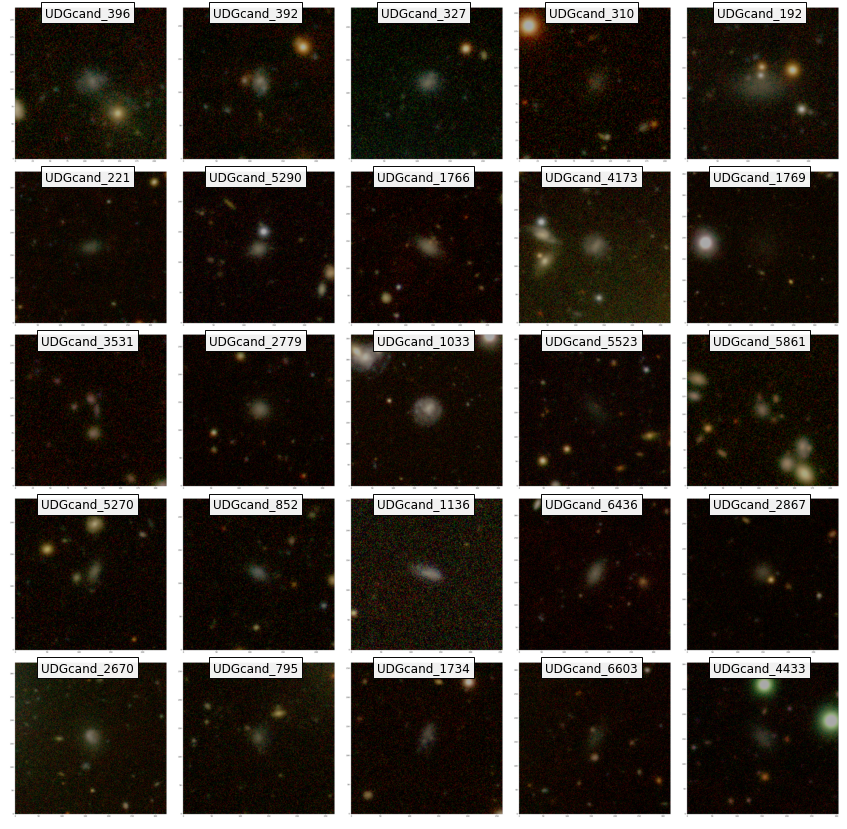

In [14]:
plot_image_grid(in_fdsdc, 5,5, savepath='some FDSDC objects.png')

## Plot the FDSDC objects and the catalogue (= likely ground truth catalogue) objects in parameter space for comparison:

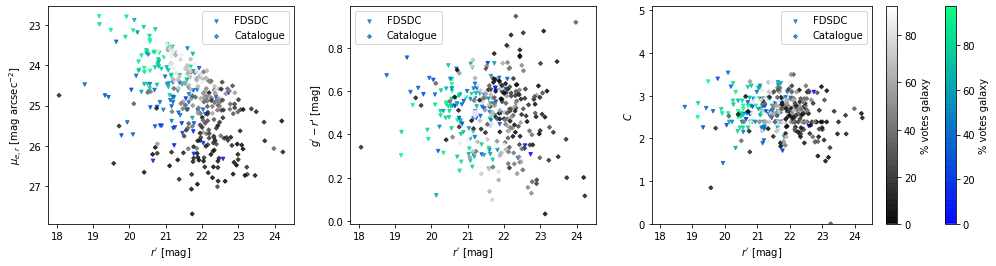

In [15]:
fig, fr = plt.subplots(1,3, figsize=(17,4), gridspec_kw=dict(width_ratios=[5,5,7]))

frames = [in_fdsdc, df_votes.query('name.isin(@catalogue_targets)')]
labels = ['FDSDC', 'Catalogue']

kw = dict(alpha=0.8, s=15, facecolor='none')
# edgecolors = ['xkcd:lightish blue', 'orange', 'green']
markers = ['v', 'D']
cmaps = ['winter', 'gray']
sizes=[12,8]
for i, d in enumerate(frames):
    kw['marker'] = markers[i]
    kw['label'] = labels[i]
    kw['c'] = d['T0 % galaxy']
    kw['cmap'] = cmaps[i]
    kw['s'] = sizes[i]
    
    sc = fr[0].scatter(d['r'], d['mue_r'], **kw)
    fr[1].scatter(d['r'], d['g']-d['r'], **kw)
    fr[2].scatter(d['r'], d['C'], **kw)
    
    cb = fig.colorbar(sc)
    cb.set_label('% votes galaxy')
    
for i in range(len(fr)):
    fr[i].legend()
    fr[i].update(dict(xlabel=r"$r'$ [mag]"))

    
fr[0].invert_yaxis()
fr[0].update(dict(
    ylabel=r"$\mu_{e,r}$ [mag arcsec$^{-2}$]"
))

fr[1].update(dict(
    ylabel=r"$g'-r$' [mag]"
))

fr[2].update(dict(
    ylim=[0, max(df_votes['C'])],
    ylabel=r"$C$"
))

plt.savefig('./fdsdc vs catalogue.png', dpi=200, bbox_inches='tight')

In [16]:
q = '`T0 % galaxy` >= 75 & `T1 % fluffy` >= 75'

in_catalogue = df_votes.query('name.isin(@catalogue_targets)')

print(in_fdsdc.shape[0], in_fdsdc.query(q).shape[0])
print(in_catalogue.shape[0], in_catalogue.query(q).shape[0])

124 39
232 30


Above: From the 124 FDSDC objects, 39 are classified by the users as fluffy galaxies. For the LGT catalogue, 30 of 232 objects are classified as fluffy galaxies.

- Finally, we can create a dataframe with objects and their coordinates in each of the datasets (first, FDSDC, then, the dataset containing all candidates considered for the LGT catalogue)

In [17]:
hdul = fits.open('./LSBS_no_par_sel.fits')
header = hdul[0].header
data = hdul[1].data

fdsdc_names = in_fdsdc['name'].tolist()
col_names = data.columns.names; print(col_names)

['target', 'RA', 'DEC', 'Reff', 'r_mag', 'g_mag', 'axis_ratio', 'pos_angle', 'n', 'u', 'g', 'r', 'i', 'ue', 'ge', 're', 'ie', 'Reffe', 'r_mage', 'ne', 'C', 'mue_r', 'bae', 'RFF']


In [18]:
df_noparsel = pd.DataFrame(np.array([d[:3] for d in data if d[0] in fdsdc_names]), columns=['name', 'RA', 'DEC'])

In [19]:
coords_merged = in_fdsdc[['name', 'RA', "DEC"]].merge(df_noparsel, on='name').rename(columns=dict(RA_x = 'RA_FDSDC', RA_y='RA_noparsel', DEC_x='DEC_FDSDC', DEC_y="DEC_noparsel"))

- Plot the difference between coordinates in each catalogue to show how close they really are:

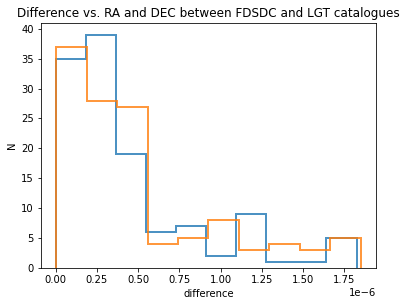

In [20]:
fig, fr = plt.subplots(figsize=(6,4.5))

hist_kw = dict(histtype='step', facecolor='none', lw=2, alpha=0.8)
fr.hist(np.abs(coords_merged['RA_FDSDC']-coords_merged['RA_noparsel'].astype('float')), **hist_kw)
fr.hist(np.abs(coords_merged['DEC_FDSDC']-coords_merged['DEC_noparsel'].astype('float')), **hist_kw)
fr.update(dict(xlabel='difference', ylabel='N', title="Difference vs. RA and DEC between FDSDC and LGT catalogues"))

plt.show()